In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,098 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and dire

In [1]:
!pip install geopandas pysal esda scikit-learn-extra

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import geopandas as gpd
import pandas as pd
import shapely.wkt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pysal.lib import weights
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from esda.moran import Moran_Local
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
from geopy.geocoders import Nominatim
from pyproj import Proj, transform

# 데이터 불러오기

## 재해대응 취약성, 물리적 취약성 데이터 분할

In [12]:
춘천_final = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/춘천_final_df.csv', index_col = 0)

In [13]:
춘천_final['geometry'] = 춘천_final['geometry'].apply(shapely.wkt.loads)

# GeoDataFrame으로 변환
춘천_gdf = gpd.GeoDataFrame(춘천_final, geometry='geometry')[춘천_final.columns]

In [14]:
춘천_gdf.columns

Index(['gid', '고령인구', 'geometry', '생산가능인구', '유아비율', '총인구', '개별주택가격', '주거용도면적',
       '공시지가', '지상층수', '용적율', '지하층수', '연면적', '높이', '건폐율', '건축면적', '전체건물수',
       '20년 이상 노후건물 수', 'value_소방서', 'value_경찰서', 'value_병원', 'value_보건기관',
       'value_응급의료시설', 'value_의원', '배수_score', '경사도_score', '산사태_길이',
       '산사태_값(합)', '높이_score', '불투수율_score', '행정동'],
      dtype='object')

In [15]:
index_col = ['gid',  'geometry', '행정동']
침수_col = ['배수_score', '경사도_score', '높이_score', '불투수율_score']
산사태_col = ['산사태_길이', '산사태_값(합)']

In [16]:
non_zero_gid = 춘천_gdf[(춘천_gdf['총인구'] != 0) & (춘천_gdf['전체건물수'] != 0)]['gid']

In [17]:
df_춘천_취약성 = 춘천_gdf[index_col + [c for c in 춘천_gdf.columns if c not in (index_col + 산사태_col + 침수_col)]]
df_춘천_산사태 = 춘천_gdf[index_col + 산사태_col]
df_춘천_침수 = 춘천_gdf[index_col + 침수_col]

In [18]:
# Min-Max 정규화
scaler = MinMaxScaler()
침수_normalized = scaler.fit_transform(df_춘천_침수[침수_col])
춘천시_침수_normalized = pd.DataFrame(침수_normalized, columns = 침수_col)

In [19]:
df_침수_normalized = pd.concat([df_춘천_침수[index_col].reset_index(drop=True), 춘천시_침수_normalized], axis = 1)

In [20]:
df_침수_normalized['침수_취약지수'] = (df_침수_normalized['배수_score'] + df_침수_normalized['불투수율_score'])/2 - (df_침수_normalized['경사도_score'] + df_침수_normalized['높이_score'])/2

In [21]:
# 산사태_길이가 0일 경우 0으로 처리하고 나머지 값에 대해서만 나누기
df_춘천_산사태['산사태_취약지수'] = np.where(df_춘천_산사태['산사태_길이'] == 0,
                                      0,
                                      (df_춘천_산사태['산사태_값(합)'] / df_춘천_산사태['산사태_길이']).round(2))

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# 산사태 LISA

In [30]:
df_춘천_산사태_filtered = df_춘천_산사태[df_춘천_산사태['산사태_취약지수'] != 0].reset_index(drop=True)

In [31]:
df_춘천_산사태_filtered['산사태_취약지수'] = 5 - (df_춘천_산사태_filtered['산사태_취약지수'])

In [32]:
# Queen 방식을 활용한 공간 가중치 생성
w = weights.Queen.from_dataframe(df_춘천_산사태_filtered)
w.transform = 'r'  # 행 단위로 표준화

# Moran's I 계산, LISA 클러스터링
lisa = Moran_Local(df_춘천_산사태_filtered['산사태_취약지수'], w)

df_춘천_산사태_filtered['LISA_I'] = lisa.Is
df_춘천_산사태_filtered['LISA_p'] = lisa.p_sim  # permutation test를 통한 p-values 값 계산
df_춘천_산사태_filtered['LISA_significance'] = np.where(lisa.p_sim < 0.05, 'Significant', 'Not Significant') # p-values < 0.05 인 값에 대해 significant 정도 부여

# Lisa cluster labels 붙이기 (1: HH, 2: LL, 3: LH, 4: HL)
df_춘천_산사태_filtered['산사태_lisa_cluster'] = 0
df_춘천_산사태_filtered.loc[(lisa.q == 1) & (lisa.p_sim < 0.05), '산사태_lisa_cluster'] = 1  # High-High
df_춘천_산사태_filtered.loc[(lisa.q == 3) & (lisa.p_sim < 0.05), '산사태_lisa_cluster'] = 2  # Low-Low
df_춘천_산사태_filtered.loc[(lisa.q == 2) & (lisa.p_sim < 0.05), '산사태_lisa_cluster'] = 3  # High-Low
df_춘천_산사태_filtered.loc[(lisa.q == 4) & (lisa.p_sim < 0.05), '산사태_lisa_cluster'] = 4  # Low-High

<ipython-input-32-61eed6c28b50>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(df_춘천_산사태_filtered)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [33]:
df_춘천_산사태_filtered['산사태_lisa_cluster'].value_counts()

,count
산사태_lisa_cluster,
0,2818
2,843
1,821
4,134
3,128


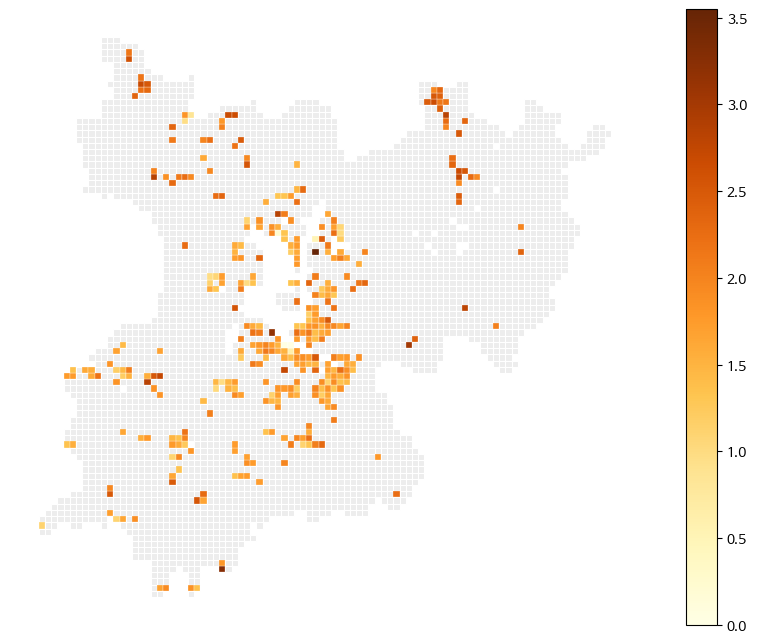

In [34]:
# 산사태 취약지역 시각화

# 배경색 정의
gray_cmap = ListedColormap(['#EDEDED'])  # LightGray

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_산사태_filtered.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.8,    # 윤곽선 두께 설정
               ax=ax,
               edgecolor='white')  # 윤곽선 색상 설정

df_춘천_산사태_filtered[(df_춘천_산사태_filtered['산사태_lisa_cluster'] != 0) & (df_춘천_산사태_filtered['gid'].isin(non_zero_gid))][['gid', 'geometry', '산사태_취약지수']].plot(column='산사태_취약지수',
        cmap='YlOrBr',  # OrRd 색상 사용 (밝은 오렌지 -> 진한 빨간)
        linewidth=0.2,  # 경계선 두께
        ax=ax,
        edgecolor='white',  # 경계선 색상
        legend=True)  # 범례 제거

# 축과 네모 박스 제거
ax.set_axis_off()

# 배경을 투명하게 설정
plt.gcf().patch.set_alpha(0)

# 시각화 출력
plt.show()

In [35]:
산사태_nonzero = df_춘천_산사태_filtered[(df_춘천_산사태_filtered['gid'].isin(non_zero_gid)) & (df_춘천_산사태_filtered['산사태_lisa_cluster'] != 0)]

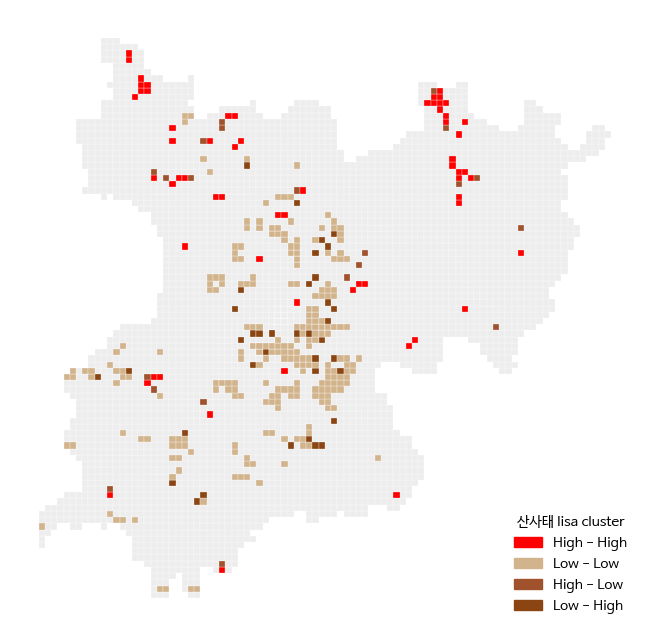

In [36]:
# 산사태 취약지역 시각화

# 배경색 정의
gray_cmap = ListedColormap(['#EDEDED'])  # LightGray

# 네 가지 갈색 계열 색상 정의
brown_cmap = ListedColormap(['Red',  # DarkBrown (매우 짙은 갈색)
                             '#D2B48C',  # Tan (밝은 갈색)
                             '#A0522D',  # Sienna (중간 갈색)
                             '#8B4513']) # SaddleBrown (짙은 갈색)

# 춘천시 전체 격자
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_산사태.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

# 춘천시 물리적 취약성(산사태) 격자
산사태_nonzero.plot(column='산사태_lisa_cluster',
               cmap=brown_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

# 새로운 범례 정의 (클러스터별 텍스트 지정)
legend_labels = ['High - High', 'Low - Low', 'High - Low', 'Low - High', ]
legend_colors = ['Red', '#D2B48C', '#A0522D', '#8B4513']

ax.set_axis_off()

patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='lower right', title='산사태 lisa cluster', frameon=True, framealpha=0)
plt.gcf().patch.set_alpha(0)

plt.show()

In [37]:
df_춘천_산사태_filtered[(df_춘천_산사태_filtered['gid'].isin(non_zero_gid)) & (df_춘천_산사태_filtered['산사태_lisa_cluster'] != 0)].groupby('산사태_lisa_cluster')['산사태_취약지수'].mean()

,산사태_취약지수
산사태_lisa_cluster,
1,2.429254
2,1.591761
3,1.870909
4,2.325102


# 침수 LISA

In [38]:
df_춘천_침수 = df_침수_normalized[index_col + ['침수_취약지수']]

In [39]:
# 산사태 과정과 동일

w = weights.Queen.from_dataframe(df_춘천_침수)
w.transform = 'r'
lisa = Moran_Local(df_춘천_침수['침수_취약지수'], w)

df_춘천_침수['LISA_I'] = lisa.Is
df_춘천_침수['LISA_p'] = lisa.p_sim  # p-values from the permutation test
df_춘천_침수['LISA_significance'] = np.where(lisa.p_sim < 0.05, 'Significant', 'Not Significant')

df_춘천_침수['침수_lisa_cluster'] = 0
df_춘천_침수.loc[(lisa.q == 1) & (lisa.p_sim < 0.05), '침수_lisa_cluster'] = 1  # High-High
df_춘천_침수.loc[(lisa.q == 3) & (lisa.p_sim < 0.05), '침수_lisa_cluster'] = 2  # Low-Low
df_춘천_침수.loc[(lisa.q == 2) & (lisa.p_sim < 0.05), '침수_lisa_cluster'] = 3  # High-Low
df_춘천_침수.loc[(lisa.q == 4) & (lisa.p_sim < 0.05), '침수_lisa_cluster'] = 4  # Low-High

<ipython-input-39-4a8548427086>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(df_춘천_침수)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super()._

In [40]:
df_춘천_침수['침수_lisa_cluster'].value_counts()

,count
침수_lisa_cluster,
0,2818
2,1149
1,997
4,47
3,44


In [41]:
df_춘천_침수.groupby('침수_lisa_cluster')['침수_취약지수'].mean().loc[1:]

,침수_취약지수
침수_lisa_cluster,
1,0.115825
2,-0.482208
3,-0.300890
4,-0.132936


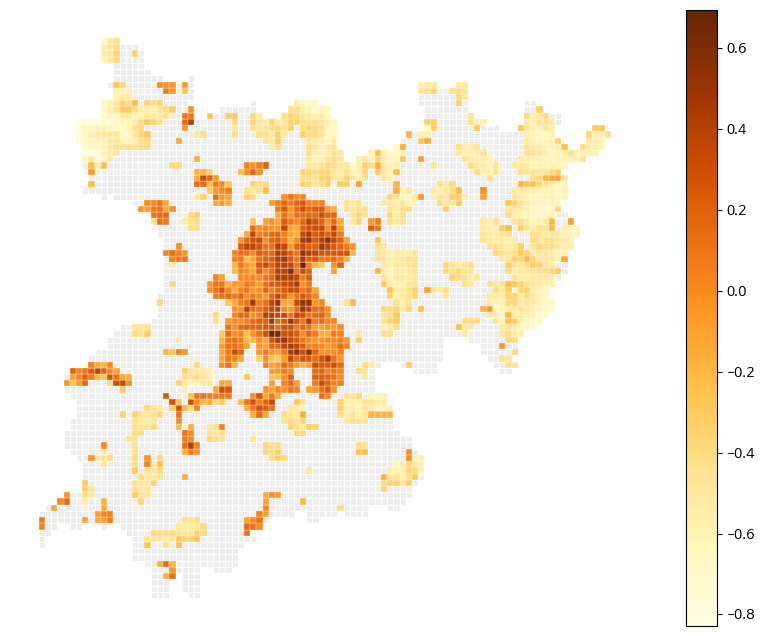

In [42]:
# 침수 클러스터링 시각화(산사태와 동일)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_침수.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='white')

df_춘천_침수[df_춘천_침수['침수_lisa_cluster'] != 0][['gid', 'geometry', '침수_취약지수']].plot(column='침수_취약지수',
        cmap='YlOrBr',
        linewidth=0.2,
        ax=ax,
        edgecolor='white',
        legend=True)

ax.set_axis_off()

plt.gcf().patch.set_alpha(0)

plt.show()

In [43]:
침수_nonzero = df_춘천_침수[(df_춘천_침수['gid'].isin(non_zero_gid)) & (df_춘천_침수['침수_lisa_cluster'] != 0)]

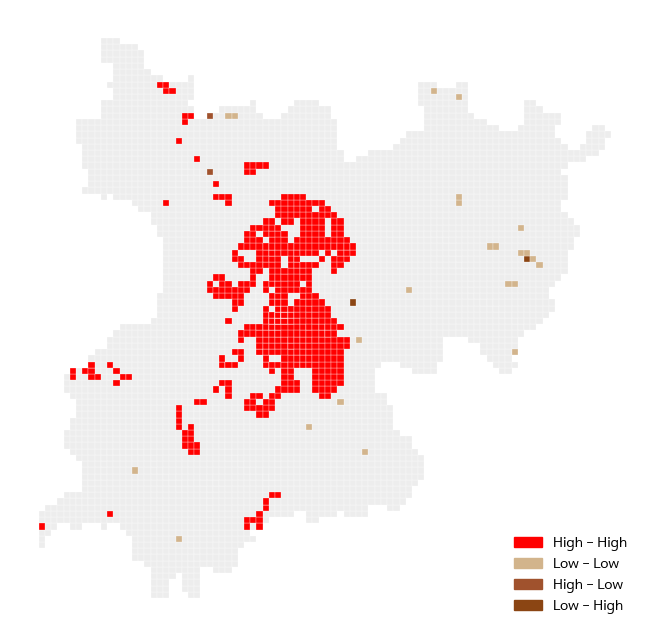

In [44]:
# 산사태 취약지역 시각화

gray_cmap = ListedColormap(['#EDEDED'])

brown_cmap = ListedColormap(['Red',
                             '#D2B48C',
                             '#A0522D',
                             '#8B4513'])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_침수.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

침수_nonzero.plot(column='침수_lisa_cluster',
               cmap=brown_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

legend_labels = ['High - High', 'Low - Low', 'High - Low', 'Low - High', ]
legend_colors = ['Red', '#D2B48C', '#A0522D', '#8B4513']

patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patches, loc='lower right', frameon=True, framealpha=0)
plt.gcf().patch.set_alpha(0)

ax.set_axis_off()

plt.show()

In [45]:
df_춘천_침수[(df_춘천_침수['gid'].isin(non_zero_gid)) & (df_춘천_침수['침수_lisa_cluster'] != 0)].groupby('침수_lisa_cluster')['침수_취약지수'].mean()

,침수_취약지수
침수_lisa_cluster,
1,0.147891
2,-0.326602
3,-0.296688
4,-0.210085


# 취약성 LISA

In [46]:
인구_col = ['고령인구', '생산가능인구', '유아비율', '총인구']
경제성_col = ['용적율', '건폐율', '공시지가', '개별주택가격']
건물_col = ['지하층수', '20년 이상 노후건물 비율','건폐율']
접근성_col = ['value_소방서', 'value_경찰서', 'value_병원', 'value_보건기관', 'value_응급의료시설', 'value_의원']

In [47]:
# 인구 지수 생성

df_population = df_춘천_취약성[인구_col]

df_population['고령인구비율'] = np.where(df_population['총인구'] == 0,
                                      0,
                                      (df_population['고령인구'] / df_population['총인구']).round(2))

df_population['생산가능인구비율'] = np.where(df_population['총인구'] == 0,
                                      0,
                                      (df_population['생산가능인구'] / df_population['총인구']).round(2))

df_population['유아인구비율'] = np.where(df_population['총인구'] == 0,
                                      0,
                                      (df_population['유아비율'] / df_population['총인구']).round(2))

# 비율 컬럼만 남기고 다른 컬럼 제거
df_population_ratio = df_population[['고령인구비율', '생산가능인구비율', '유아비율']]

<ipython-input-47-5abb681a205f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_population['고령인구비율'] = np.where(df_population['총인구'] == 0,
<ipython-input-47-5abb681a205f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_population['생산가능인구비율'] = np.where(df_population['총인구'] == 0,
<ipython-input-47-5abb681a205f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [48]:
# 건물 지수 생성

df_춘천_취약성['20년이상노후건물비율'] = np.where(df_춘천_취약성['전체건물수'] == 0,
                                      0,
                                      (df_춘천_취약성['20년 이상 노후건물 수'] / df_춘천_취약성['전체건물수']).round(2))

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
df_춘천_취약성_calculate = pd.concat([df_춘천_취약성[[c for c in df_춘천_취약성.columns if c not in 인구_col]].reset_index(drop=True), df_population_ratio.reset_index(drop=True)],axis=1)

In [50]:
df_춘천_취약성_calculate.drop(['주거용도면적', '용적율', '지상층수', '연면적', '높이', '건축면적', '전체건물수', '20년 이상 노후건물 수', 'value_보건기관', 'value_의원'],axis=1,inplace=True)

In [51]:
df_춘천_취약성_calculate.columns

Index(['gid', 'geometry', '행정동', '개별주택가격', '공시지가', '지하층수', '건폐율', 'value_소방서',
       'value_경찰서', 'value_병원', 'value_응급의료시설', '20년이상노후건물비율', '고령인구비율',
       '생산가능인구비율', '유아비율'],
      dtype='object')

In [52]:
취약성_value_col = [c for c in df_춘천_취약성_calculate.columns if c not in index_col]

In [53]:
# Min-Max 정규화
scaler = MinMaxScaler()
취약성_normalized = scaler.fit_transform(df_춘천_취약성_calculate[취약성_value_col])
취약성_normalized = pd.DataFrame(취약성_normalized, columns = 취약성_value_col)

In [54]:
def cal_sensitivity(row):
    # 인구 지수 계산
    population_index = (row['유아비율'] + row['고령인구비율'])/2

    # 건물 지수 계산
    building_index = (row['지하층수'] + row['20년이상노후건물비율'] + row['건폐율'])/3

    # 접근성 지수 계산
    accessibility_index = (row['value_소방서'] + row['value_경찰서'] + row['value_병원'] + row['value_응급의료시설']) / 4

    # 회복성 지수 계산
    economy_index = (row['공시지가'] + row['개별주택가격'] + row['생산가능인구비율']) / 3

    # 민감성 지수 계산
    sensitivity_index = population_index + building_index + accessibility_index - economy_index

    return sensitivity_index

In [55]:
# 취약성 지수 생성

취약성_normalized['취약성_지수'] = 취약성_normalized.apply(cal_sensitivity, axis=1)
df_취약성 = pd.concat([df_춘천_취약성_calculate[index_col], 취약성_normalized['취약성_지수']],axis=1)

In [56]:
# 취약성 지수 clustering

w = weights.Queen.from_dataframe(df_취약성)
w.transform = 'r'

lisa = Moran_Local(df_취약성['취약성_지수'], w)

df_취약성['LISA_I'] = lisa.Is
df_취약성['LISA_p'] = lisa.p_sim
df_취약성['LISA_significance'] = np.where(lisa.p_sim < 0.05, 'Significant', 'Not Significant')

df_취약성['취약성_lisa_cluster'] = 0
df_취약성.loc[(lisa.q == 1) & (lisa.p_sim < 0.05), '취약성_lisa_cluster'] = 1  # High-High
df_취약성.loc[(lisa.q == 3) & (lisa.p_sim < 0.05), '취약성_lisa_cluster'] = 2  # Low-Low
df_취약성.loc[(lisa.q == 2) & (lisa.p_sim < 0.05), '취약성_lisa_cluster'] = 3  # High-Low
df_취약성.loc[(lisa.q == 4) & (lisa.p_sim < 0.05), '취약성_lisa_cluster'] = 4  # Low-High

<ipython-input-56-d919d1d30112>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(df_취약성)


In [57]:
취약성_normalized['취약성_lisa_cluster'] = df_취약성['취약성_lisa_cluster']

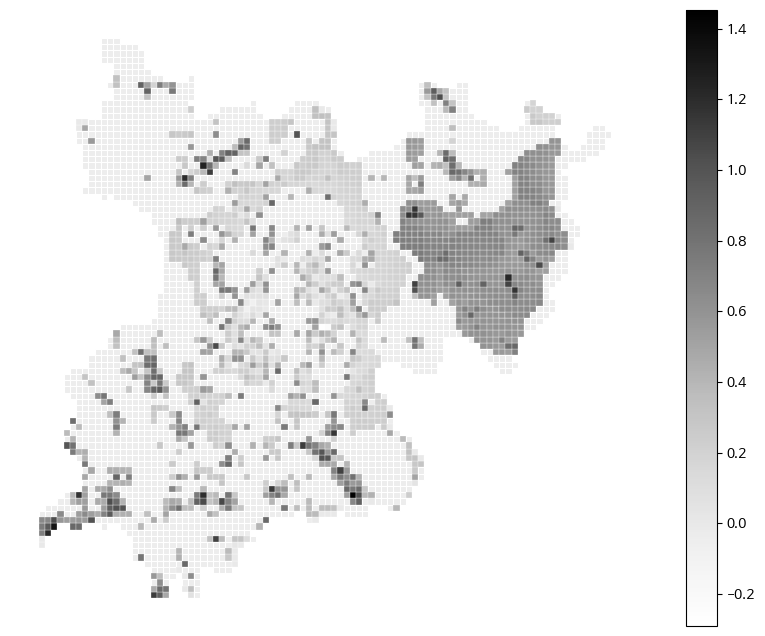

In [58]:
# 침수 지수 시각화

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_취약성.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='white')

df_취약성[df_취약성['취약성_lisa_cluster'] != 0][['gid', 'geometry', '취약성_지수']].plot(column='취약성_지수',
        cmap='Greys',
        linewidth=0.2,
        ax=ax,
        edgecolor='white',
        legend=True)

ax.set_axis_off()

plt.gcf().patch.set_alpha(0)

plt.show()

In [59]:
취약성_normalized.groupby('취약성_lisa_cluster')['취약성_지수'].mean()

,취약성_지수
취약성_lisa_cluster,
0,0.422359
1,0.656633
2,0.201432
3,0.317366
4,0.573826


In [60]:
취약성_nonzero = df_취약성[df_취약성['gid'].isin(non_zero_gid)]
취약성_nonzero['취약성_lisa_cluster'].value_counts()

,count
취약성_lisa_cluster,
0,769
1,221
2,185
4,88
3,36


In [61]:
취약성_nonzero.groupby('취약성_lisa_cluster')['취약성_지수'].mean()

,취약성_지수
취약성_lisa_cluster,
0,0.510774
1,0.750366
2,0.203389
3,0.290463
4,0.576583


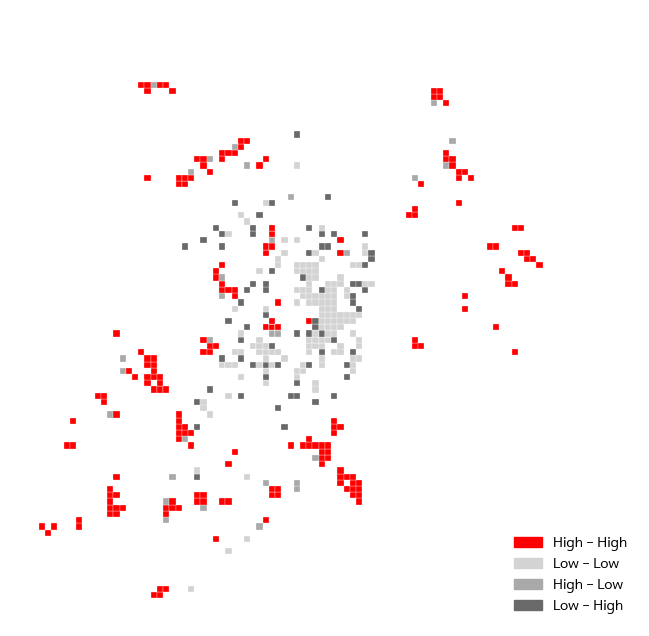

In [62]:
# 재해대응 취약성 Lisa Custering 시각화

gray_cmap = ListedColormap(['#FFFFFF']) # 배경색

# 클러스터별 색 정의
grays_cmap = ListedColormap(['Red',  # 더 짙은 회색
                             '#D3D3D3',  # 덜 밝은 회색
                             '#A9A9A9',  # 좀 더 진한 밝은 회색
                             '#696969']) # 더 진한 중간 회색


# 춘천시 전체 배경 생성
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_취약성.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

# 재해대응 취약성 시각화
취약성_nonzero[취약성_nonzero['취약성_lisa_cluster'] != 0].plot(column='취약성_lisa_cluster',
               cmap=grays_cmap,
               legend=False,
               linewidth=0.2,
               ax=ax,
               edgecolor='white')

# 새로운 범례 정의 (클러스터별 텍스트 지정)
legend_labels = ['High - High', 'Low - Low', 'High - Low', 'Low - High']
legend_colors = ['Red',
                             '#D3D3D3',
                             '#A9A9A9',
                             '#696969']

patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.legend(handles=patches, loc='lower right', frameon=True, framealpha=0)

ax.set_axis_off()

plt.gcf().patch.set_alpha(0)

plt.show()

In [63]:
취약성_nonzero[취약성_nonzero['취약성_lisa_cluster'] != 0].groupby('취약성_lisa_cluster')['취약성_지수'].mean()

,취약성_지수
취약성_lisa_cluster,
1,0.750366
2,0.203389
3,0.290463
4,0.576583


# 강우 데이터

In [64]:
# 춘천시 행정동 경계 데이터
df_geo = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/gangwu_10_06_2300.csv')
df_geo = df_geo.iloc[:,1:].copy()
df_geo.drop(['읍면동','geometry_y','geometry'], axis=1, inplace=True)
geo_dict = df_geo[~df_geo['행정동'].duplicated()][['geometry_x', '행정동']].set_index('행정동')['geometry_x'].to_dict()

In [65]:
# 2026년 강우량 데이터
df_cli_2026 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2026.csv')
df_cli_2026 = df_cli_2026.iloc[:,1:].copy()

# 2027년 강우량 데이터
df_cli_2027 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2027.csv')
df_cli_2027 = df_cli_2027.iloc[:,1:].copy()

# 2028년 강우량 데이터
df_cli_2028 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2028.csv')
df_cli_2028 = df_cli_2028.iloc[:,1:].copy()

# 2029년 강우량 데이터
df_cli_2029 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2029.csv')
df_cli_2029 = df_cli_2029.iloc[:,1:].copy()

# 2030년 강우량 데이터
df_cli_2030 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2030.csv')
df_cli_2030 = df_cli_2030.iloc[:,1:].copy()

# 2031년 강우량 데이터
df_cli_2031 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2031.csv')
df_cli_2031 = df_cli_2031.iloc[:,1:].copy()

# 2032년 강우량 데이터
df_cli_2032 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2032.csv')
df_cli_2032 = df_cli_2032.iloc[:,1:].copy()

# 2033년 강우량 데이터
df_cli_2033 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2033.csv')
df_cli_2033 = df_cli_2033.iloc[:,1:].copy()

# 2034년 강우량 데이터
df_cli_2034 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2034.csv')
df_cli_2034 = df_cli_2034.iloc[:,1:].copy()

# 2035년 강우량 데이터
df_cli_2035 = pd.read_csv('/content/drive/MyDrive/도균 근우/춘천시/분석/강우량/df_cli_2035.csv')
df_cli_2035 = df_cli_2035.iloc[:,1:].copy()

# '춘천시' 없애기 : 행정동이 춘천시인 행을 제거(2026~2035)
df_cli_2026.drop(df_cli_2026[df_cli_2026['행정동'] == '춘천시'].index, inplace=True)
df_cli_2027.drop(df_cli_2027[df_cli_2027['행정동'] == '춘천시'].index, inplace=True)
df_cli_2028.drop(df_cli_2028[df_cli_2028['행정동'] == '춘천시'].index, inplace=True)
df_cli_2029.drop(df_cli_2029[df_cli_2029['행정동'] == '춘천시'].index, inplace=True)
df_cli_2030.drop(df_cli_2030[df_cli_2030['행정동'] == '춘천시'].index, inplace=True)
df_cli_2031.drop(df_cli_2031[df_cli_2031['행정동'] == '춘천시'].index, inplace=True)
df_cli_2032.drop(df_cli_2032[df_cli_2032['행정동'] == '춘천시'].index, inplace=True)
df_cli_2033.drop(df_cli_2033[df_cli_2033['행정동'] == '춘천시'].index, inplace=True)
df_cli_2034.drop(df_cli_2034[df_cli_2034['행정동'] == '춘천시'].index, inplace=True)
df_cli_2035.drop(df_cli_2035[df_cli_2035['행정동'] == '춘천시'].index, inplace=True)

In [66]:
yearly_cli = [df_cli_2026, df_cli_2027, df_cli_2028, df_cli_2029, df_cli_2030, df_cli_2031, df_cli_2032, df_cli_2033, df_cli_2034, df_cli_2035]
yearly_cli_total = pd.concat(yearly_cli, axis=0, ignore_index=True)

In [67]:
df = yearly_cli_total

# 각 연도에 대해 quntile 분석 수행
def calculate_extreme_rain(df):
    df['극한강우'] = (df['재해 유발 강우 지수'] >= df['재해 유발 강우 지수'].quantile(0.75)).astype(int)
    return df

# 연도별로 필터링 후 작업 수행 및 병합
df_rain_final = pd.concat([calculate_extreme_rain(df[df['기간'] == year]) for year in df['기간'].unique()])

<ipython-input-67-3644830fe9e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['극한강우'] = (df['재해 유발 강우 지수'] >= df['재해 유발 강우 지수'].quantile(0.75)).astype(int)
<ipython-input-67-3644830fe9e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['극한강우'] = (df['재해 유발 강우 지수'] >= df['재해 유발 강우 지수'].quantile(0.75)).astype(int)
<ipython-input-67-3644830fe9e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [68]:
df_rain_취약성 = df_rain_final[df_rain_final['극한강우'] == 1]

In [69]:
df_rain_취약성.groupby(['행정동'])['극한강우'].count()

,극한강우
행정동,
강남동,1
근화동,4
남면,5
남산면,8
동내면,6
동면,2
동산면,6
사북면,5
서면,9


<ipython-input-70-1dd34a7f71a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2026_sample['geometry'] = df_2026_sample['행정동'].map(geo_dict)
<ipython-input-70-1dd34a7f71a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2026_sample['geometry'] = df_2026_sample['geometry'].apply(shapely.wkt.loads)


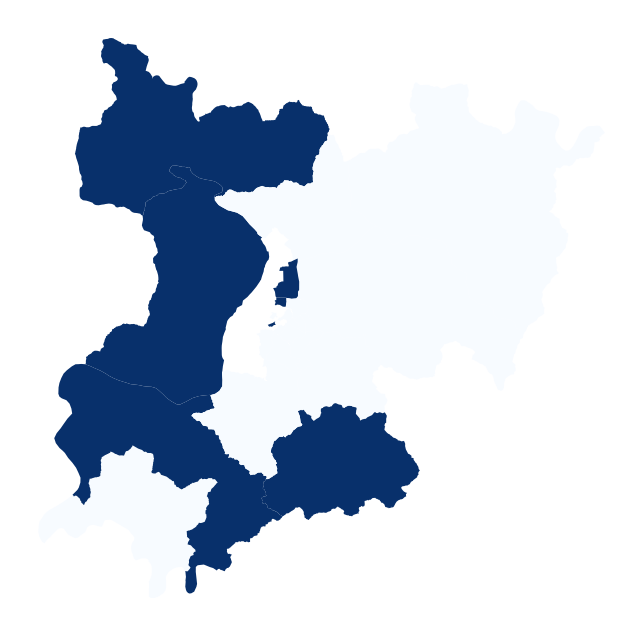

In [70]:
# 극한강우에 따라 지도 시각화 - 2026년 예시

df_2026_sample = df_rain_final[df_rain_final['기간'] == '2026년']
df_2026_sample['geometry'] = df_2026_sample['행정동'].map(geo_dict)
df_2026_sample['geometry'] = df_2026_sample['geometry'].apply(shapely.wkt.loads)

gdf = gpd.GeoDataFrame(df_2026_sample, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_plot = gdf.plot(column='극한강우', ax=ax, legend=False, cmap='Blues')

cbar = plt.cm.ScalarMappable(cmap='Blues')
cbar.set_array(gdf['극한강우'])
ax.set_axis_off()

plt.gcf().patch.set_alpha(0)
plt.show()

<ipython-input-71-88e4301c0ec1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_취약성_최종_시각화['geometry'] = df_취약성_최종_시각화['행정동'].map(geo_dict)
<ipython-input-71-88e4301c0ec1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_취약성_최종_시각화['geometry'] = df_취약성_최종_시각화['geometry'].apply(shapely.wkt.loads)


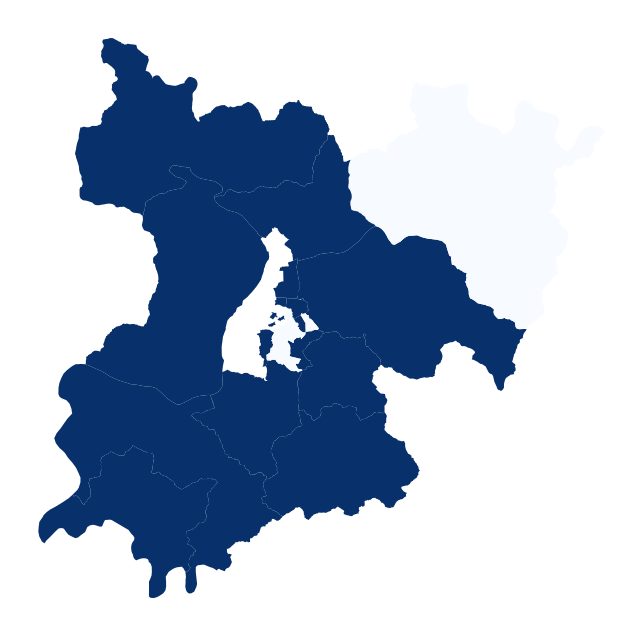

In [71]:
# 강우 취약지역 시각화

df_취약성_최종_시각화 = df_rain_취약성[~df_rain_취약성['행정동'].duplicated()]
df_취약성_최종_시각화['geometry'] = df_취약성_최종_시각화['행정동'].map(geo_dict)
df_취약성_최종_시각화['geometry'] = df_취약성_최종_시각화['geometry'].apply(shapely.wkt.loads)

df_강우_시각화 = df_2026_sample.copy()
df_강우_시각화.index = df_강우_시각화['행정동']
df_강우_시각화.loc[list(df_취약성_최종_시각화['행정동']),'극한강우'] = 1

gdf = gpd.GeoDataFrame(df_강우_시각화, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_plot = gdf.plot(column='극한강우', ax=ax, legend=False, cmap='Blues')

cbar = plt.cm.ScalarMappable(cmap='Blues')
cbar.set_array(gdf['극한강우'])

ax.set_axis_off()

plt.gcf().patch.set_alpha(0)
plt.show()

In [72]:
filtered_rain = list(df_강우_시각화[df_강우_시각화['극한강우'] == 1]['행정동'])

# 교차분석

In [73]:
취약성_nonzero.head()

,gid,geometry,행정동,취약성_지수,LISA_I,LISA_p,LISA_significance,취약성_lisa_cluster
3,라사00b69b,"POLYGON ((1000500 1969500, 1000500 1970000, 10...",남면,0.739113,2.931219,0.001,Significant,1
6,라사01a69a,"POLYGON ((1001000 1969000, 1001000 1969500, 10...",남면,1.223769,5.654074,0.001,Significant,1
11,라사01b69b,"POLYGON ((1001500 1969500, 1001500 1970000, 10...",남면,1.318728,9.177440,0.001,Significant,1
24,라사02b76a,"POLYGON ((1002500 1976000, 1002500 1976500, 10...",남산면,0.983315,2.840355,0.020,Significant,1
29,라사02b81b,"POLYGON ((1002500 1981500, 1002500 1982000, 10...",남산면,0.909385,0.139838,0.404,Not Significant,0


In [74]:
# 먼저 df1과 df2를 병합하고, 그 결과를 df3와 병합합니다.
df_침수_분석_normalized = pd.merge(취약성_nonzero[취약성_nonzero['취약성_lisa_cluster'] == 1], 침수_nonzero[침수_nonzero['침수_lisa_cluster'] == 1], on=['gid', 'geometry', '행정동'], how='outer')
df_산사태_분석_normalized = pd.merge(취약성_nonzero[취약성_nonzero['취약성_lisa_cluster'] == 1], 산사태_nonzero[산사태_nonzero['산사태_lisa_cluster'] == 1], on=['gid', 'geometry', '행정동'], how='outer')

In [75]:
df_침수_분석_normalized.fillna(0, inplace=True)
df_산사태_분석_normalized.fillna(0, inplace=True)

### 침수

In [76]:
df_침수_분석_normalized.columns

Index(['gid', 'geometry', '행정동', '취약성_지수', 'LISA_I_x', 'LISA_p_x',
       'LISA_significance_x', '취약성_lisa_cluster', '침수_취약지수', 'LISA_I_y',
       'LISA_p_y', 'LISA_significance_y', '침수_lisa_cluster'],
      dtype='object')

In [77]:
# 침수 and 재해대응, 침수, 재해대응 각각에 대해 정의
conditions = [
    (df_침수_분석_normalized['침수_lisa_cluster'] == 1) & (df_침수_분석_normalized['취약성_lisa_cluster'] == 1),
    (df_침수_분석_normalized['침수_lisa_cluster'] == 1),
    (df_침수_분석_normalized['취약성_lisa_cluster'] == 1)
]

choices = ['침수 and 취약성', '침수', '취약성']

df_침수_분석_normalized['region'] = np.select(conditions, choices, default=np.nan)

In [78]:
df_침수_분석_normalized['region'].value_counts()

,count
region,
침수,631
취약성,165
침수 and 취약성,134


### 산사태

In [79]:
df_산사태_분석_normalized.columns

Index(['gid', 'geometry', '행정동', '취약성_지수', 'LISA_I_x', 'LISA_p_x',
       'LISA_significance_x', '취약성_lisa_cluster', '산사태_길이', '산사태_값(합)',
       '산사태_취약지수', 'LISA_I_y', 'LISA_p_y', 'LISA_significance_y',
       '산사태_lisa_cluster'],
      dtype='object')

In [80]:
# 산사태 and 재해대응, 산사태, 재해대응 각각에 대해 정의
conditions = [
    (df_산사태_분석_normalized['산사태_lisa_cluster'] == 1) & (df_산사태_분석_normalized['취약성_lisa_cluster'] == 1),
    (df_산사태_분석_normalized['산사태_lisa_cluster'] == 1),
    (df_산사태_분석_normalized['취약성_lisa_cluster'] == 1)
]

choices = ['산사태 and 취약성', '산사태', '취약성']

df_산사태_분석_normalized['region'] = np.select(conditions, choices, default=np.nan)

In [81]:
df_산사태_분석_normalized['region'].value_counts()

,count
region,
취약성,195
산사태,41
산사태 and 취약성,30


In [82]:
list(set(df_산사태_분석_normalized['region']))

['산사태 and 취약성', '산사태', '취약성']

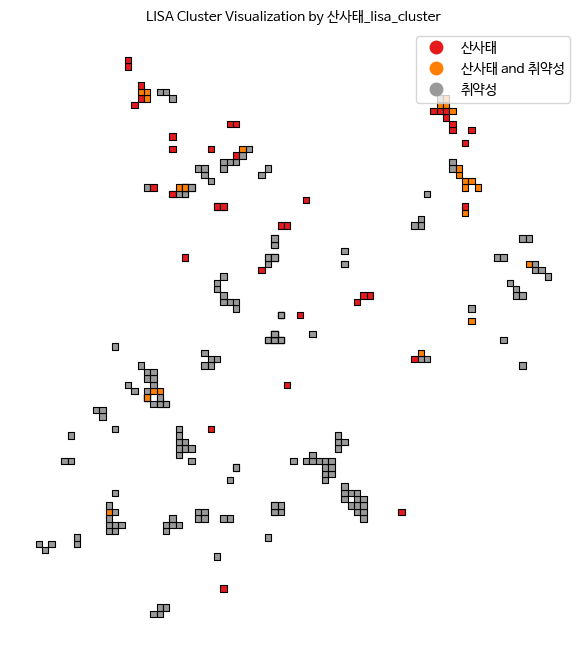

In [83]:
# 산사태_lisa_cluster 기준으로 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_산사태_분석_normalized.plot(column='region',
               cmap='Set1',  # 원하는 컬러맵 선택
               legend=True,
               linewidth=0.8,
               ax=ax,
               edgecolor='black')

# 제목과 축 제거
ax.set_title('LISA Cluster Visualization by 산사태_lisa_cluster', fontsize=10)
ax.set_axis_off()

# 시각화 출력
plt.show()

# 강우 필터링

In [84]:
침수_final = df_침수_분석_normalized[df_침수_분석_normalized['행정동'].isin(filtered_rain)].reset_index(drop=True)
침수_final[침수_final['region'] == '침수 and 취약성']

,gid,geometry,행정동,취약성_지수,LISA_I_x,LISA_p_x,LISA_significance_x,취약성_lisa_cluster,침수_취약지수,LISA_I_y,LISA_p_y,LISA_significance_y,침수_lisa_cluster,region
0,라사00b69b,"POLYGON ((1000500 1969500, 1000500 1970000, 10...",남면,0.739113,2.931219,0.001,Significant,1.0,0.024752,0.825911,0.043,Significant,1.0,침수 and 취약성
19,라사06a70b,"POLYGON ((1006000 1970500, 1006000 1971000, 10...",남면,0.961080,1.706176,0.038,Significant,1.0,0.056793,0.800110,0.030,Significant,1.0,침수 and 취약성
71,라사11b77b,"POLYGON ((1011500 1977500, 1011500 1978000, 10...",남산면,0.585327,0.890749,0.002,Significant,1.0,-0.213920,0.003931,0.044,Significant,1.0,침수 and 취약성
72,라사11b78a,"POLYGON ((1011500 1978000, 1011500 1978500, 10...",남산면,0.679620,0.963857,0.014,Significant,1.0,0.010417,0.576243,0.049,Significant,1.0,침수 and 취약성
73,라사11b78b,"POLYGON ((1011500 1978500, 1011500 1979000, 10...",남산면,0.662336,1.015686,0.006,Significant,1.0,0.096168,0.834965,0.039,Significant,1.0,침수 and 취약성
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,라사24b91b,"POLYGON ((1024500 1991500, 1024500 1992000, 10...",신북읍,0.487375,0.157190,0.024,Significant,1.0,0.280544,3.240979,0.001,Significant,1.0,침수 and 취약성
741,라사24b92b,"POLYGON ((1024500 1992500, 1024500 1993000, 10...",신북읍,0.466163,0.115018,0.031,Significant,1.0,0.200999,2.465023,0.001,Significant,1.0,침수 and 취약성
776,라아10a05a,"POLYGON ((1010000 2005000, 1010000 2005500, 10...",사북면,0.728356,1.196036,0.015,Significant,1.0,-0.005223,0.670683,0.030,Significant,1.0,침수 and 취약성
778,라아10b05a,"POLYGON ((1010500 2005000, 1010500 2005500, 10...",사북면,0.464869,0.262921,0.002,Significant,1.0,-0.021375,0.736540,0.017,Significant,1.0,침수 and 취약성


In [85]:
산사태_final = df_산사태_분석_normalized[df_산사태_분석_normalized['행정동'].isin(filtered_rain)].reset_index(drop=True)
산사태_final[산사태_final['region'] == '산사태 and 취약성']

,gid,geometry,행정동,취약성_지수,LISA_I_x,LISA_p_x,LISA_significance_x,취약성_lisa_cluster,산사태_길이,산사태_값(합),산사태_취약지수,LISA_I_y,LISA_p_y,LISA_significance_y,산사태_lisa_cluster,region
14,라사06a72a,"POLYGON ((1006000 1972000, 1006000 1972500, 10...",남면,0.778466,1.902997,0.002,Significant,1.0,1099.0,2748.0,2.50,0.558237,0.043,Significant,1.0,산사태 and 취약성
26,라사09a81a,"POLYGON ((1009000 1981000, 1009000 1981500, 10...",서면,0.697964,1.138589,0.003,Significant,1.0,1436.0,3120.0,2.83,1.980028,0.001,Significant,1.0,산사태 and 취약성
27,라사09a81a,"POLYGON ((1009000 1981000, 1009000 1981500, 10...",서면,0.697964,1.138589,0.003,Significant,1.0,1436.0,3120.0,2.83,1.980028,0.001,Significant,1.0,산사태 and 취약성
28,라사09a81a,"POLYGON ((1009000 1981000, 1009000 1981500, 10...",서면,0.697964,1.138589,0.003,Significant,1.0,1436.0,3120.0,2.83,1.980028,0.001,Significant,1.0,산사태 and 취약성
29,라사09a81a,"POLYGON ((1009000 1981000, 1009000 1981500, 10...",서면,0.697964,1.138589,0.003,Significant,1.0,1436.0,3120.0,2.83,1.980028,0.001,Significant,1.0,산사태 and 취약성
36,라사09b81b,"POLYGON ((1009500 1981500, 1009500 1982000, 10...",서면,0.880897,1.607981,0.010,Significant,1.0,2179.0,5420.0,2.51,0.886995,0.003,Significant,1.0,산사태 and 취약성
47,라사10a81b,"POLYGON ((1010000 1981500, 1010000 1982000, 10...",서면,0.878506,1.233205,0.038,Significant,1.0,2347.0,5338.0,2.73,1.018833,0.017,Significant,1.0,산사태 and 취약성
65,라사11b97b,"POLYGON ((1011500 1997500, 1011500 1998000, 10...",사북면,0.570387,0.432747,0.013,Significant,1.0,2093.0,6054.0,2.11,0.062843,0.026,Significant,1.0,산사태 and 취약성
71,라사12a97b,"POLYGON ((1012000 1997500, 1012000 1998000, 10...",서면,1.197876,2.627369,0.003,Significant,1.0,3764.0,10268.0,2.27,0.244669,0.035,Significant,1.0,산사태 and 취약성
72,라사12a97b,"POLYGON ((1012000 1997500, 1012000 1998000, 10...",서면,1.197876,2.627369,0.003,Significant,1.0,3764.0,10268.0,2.27,0.244669,0.035,Significant,1.0,산사태 and 취약성


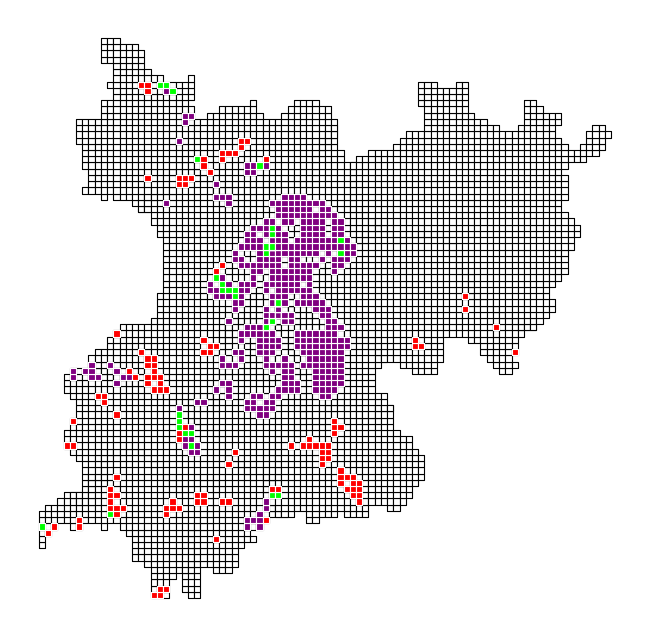

In [86]:
# 교차분석 및 강우 필터링 시각화 - 침수

gray_cmap = ListedColormap(['#FFFFFF'])

pastel_cmap = ListedColormap(['Red', 'Purple', 'Lime'])
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_침수.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='black')

침수_final.plot(column='region',
               cmap=pastel_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='white')

legend_labels = list(set(침수_final['region']))
legend_colors = ['Red', 'Purple', 'Lime']


patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.gcf().patch.set_alpha(0)
ax.set_axis_off()

plt.show()

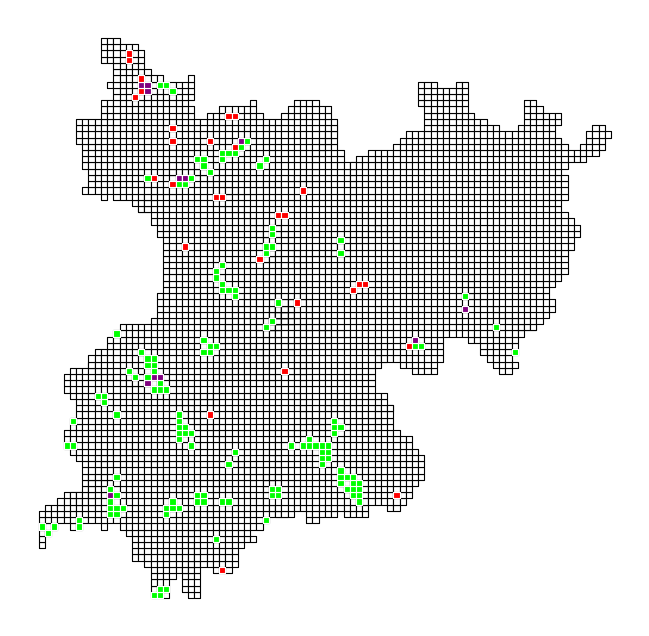

In [87]:
# # 교차분석 및 강우 필터링 시각화 - 산사태

gray_cmap = ListedColormap(['#FFFFFF'])

pastel_cmap = ListedColormap(['Red', 'Purple', 'Lime'])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df_춘천_산사태.plot(column='gid',
               cmap=gray_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='black')

산사태_final.plot(column='region',
               cmap=pastel_cmap,
               legend=False,
               linewidth=0.8,
               ax=ax,
               edgecolor='white')

legend_labels = list(set(산사태_final['region']))
legend_colors = ['Red', 'Purple', 'Lime']

patches = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.gcf().patch.set_alpha(0)

ax.set_axis_off()

plt.show()

# 취약지역 gid -> 주소 변환

In [88]:
침수_gid = 침수_final[['gid','geometry','행정동','region']].reset_index(drop=True)
산사태_gid = 산사태_final[['gid','geometry','행정동','region']].reset_index(drop=True)

In [89]:
# Nominatim 객체 생성
geo_local = Nominatim(user_agent='South Korea', timeout=10)

# 좌표 변환: EPSG 5179 -> EPSG 4326
def convert_epsg5179_to_wgs84(lat, lng):
    proj_5179 = Proj(init='epsg:5179')
    proj_4326 = Proj(init='epsg:4326')
    lng_wgs84, lat_wgs84 = transform(proj_5179, proj_4326, lng, lat)
    return lat_wgs84, lng_wgs84

# 역 지오코딩 함수
def geocoding_reverse(lat, lng):
    try:
        address = geo_local.reverse([lat, lng], exactly_one=True, language='ko')
        return address.address
    except Exception as e:
        print(f"Error: {e}")
        return None

# Polygon의 중심 좌표를 계산하고, 해당 좌표의 주소를 반환하는 함수
def get_address_from_polygon(geopolygon_wkt):
    # geopolygon = loads(geopolygon_wkt)
    center_point = geopolygon_wkt.centroid
    center_lat, center_lng = center_point.y, center_point.x

    # EPSG:5179에서 WGS84로 변환
    center_lat_wgs84, center_lng_wgs84 = convert_epsg5179_to_wgs84(center_lat, center_lng)

    # 변환된 좌표로 역 지오코딩 수행
    address = geocoding_reverse(center_lat_wgs84, center_lng_wgs84)
    return address

In [ ]:
# 'geometry' 컬럼에 있는 WKT 형식을 사용하여 주소를 얻고, 이를 '주소'라는 새로운 컬럼으로 추가
침수_gid['주소'] = 침수_gid['geometry'].apply(lambda x: get_address_from_polygon(x))
산사태_gid['주소'] = 산사태_gid['geometry'].apply(lambda x: get_address_from_polygon(x))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-89-14e1c9832d9a>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lng_wgs84, lat_wgs84 = transform(proj_5179, proj_4326, lng, lat)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_

In [ ]:
산사태_final_gid = 산사태_gid[~산사태_gid['주소'].duplicated()]
침수_final_gid = 침수_gid[~침수_gid['주소'].duplicated()]

In [ ]:
침수_final_gid.to_excel('침수_fianl_gid.xlsx')
산사태_final_gid.to_excel('산사태_fianl_gid.xlsx')